# Manufacturing Quality Control with Quality Charts
### Problem:
A factory tracks defect rates on an assembly line and needs to detect shifts in quality.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Simulate 60 days of defect data
np.random.seed(42)
days=pd.date_range(start='2024-01-01', periods=60)
sample_size = np.random.randint(80,120,size=60) # daily sample size
true_defect_rate=0.05

# Simulate daily defect counts
defect_count=np.random.binomial(sample_size,true_defect_rate)

df=pd.DataFrame({
    'Date':days,
    'Sample_Size':sample_size,
    'Defects':defect_count
})
df['Defects_Rate']=df['Defects']/df['Sample_Size']
print(df.head())

        Date  Sample_Size  Defects  Defects_Rate
0 2024-01-01          118        5      0.042373
1 2024-01-02          108        9      0.083333
2 2024-01-03           94        6      0.063830
3 2024-01-04           87        3      0.034483
4 2024-01-05          100        5      0.050000


In [3]:
# Overall average defect rate
p_bar = df['Defects'].sum()/df['Sample_Size'].sum()

# Control limits
df['p_bar']=p_bar
df['UCL'] = p_bar + 3 * np.sqrt((p_bar*(1-p_bar))/df['Sample_Size'])
df['LCL'] = p_bar - 3 * np.sqrt((p_bar*(1-p_bar))/df['Sample_Size'])
df['LCL'] = df['LCL'].clip(lower=0)   # LCL can't be negative

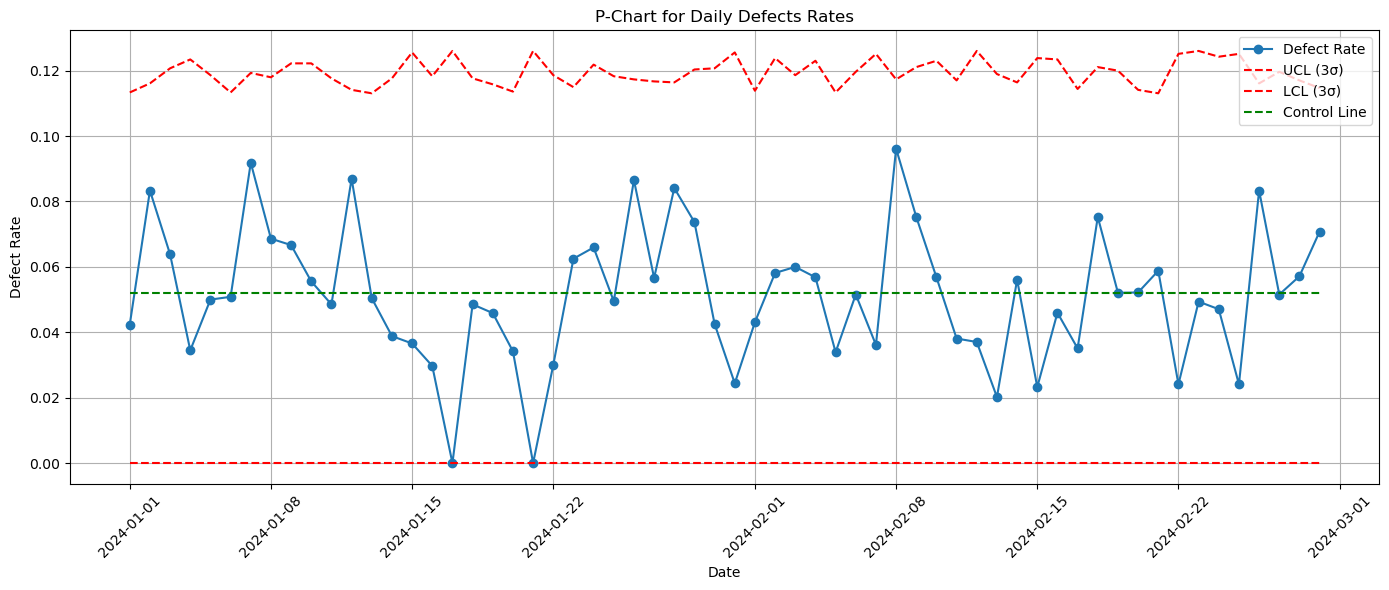

In [4]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defects_Rate'],marker='o',label='Defect Rate')
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3σ)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3σ)')
plt.plot(df['Date'],df['p_bar'],linestyle='--',color='green',label='Control Line')
plt.title('P-Chart for Daily Defects Rates')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df['Out_Of_Control']=(df['Defects_Rate']>df['UCL'])|(df['Defects_Rate']<df['LCL'])

# Show flagged days
print(df[df['Out_Of_Control']][['Date','Defects_Rate','UCL','LCL']])

Empty DataFrame
Columns: [Date, Defects_Rate, UCL, LCL]
Index: []


In [6]:
from statsmodels.stats.proportion import proportions_ztest

#Test if last day's defect rate is significantly higher than average
last=df.iloc[-1]
count=last['Defects']
nobs=last['Sample_Size']

stat,pval=proportions_ztest(count,nobs,value=p_bar,alternative='larger')
print(f"Z-stat:{stat:.2f}, p-value:{pval:.4f}")

if pval<0.05:
    print("Statistically Significant increase in defects!")
else:
    print("No significant shift detected")

Z-stat:0.78, p-value:0.2181
No significant shift detected


# Introduce a shift in defect rate on day 35

In [26]:
# Introduce a shift in the defect rate on day 35
df.loc[35:,'Defects']=np.random.binomial(df.loc[35:,'Sample_Size'],0.10)  # Double the defect rate
df['Defects_Rate']=df['Defects']/df['Sample_Size']

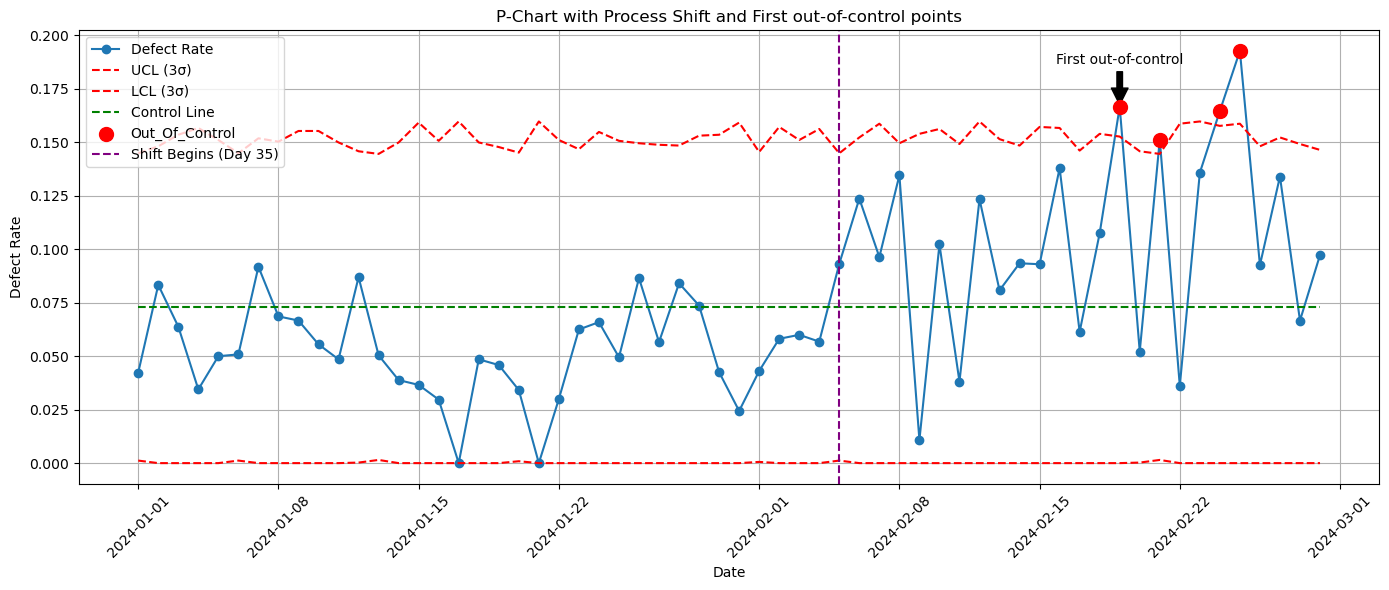

In [27]:
import matplotlib.pyplot as plt

# Recalculate p_var and control limits
p_bar = df['Defects'].sum()/df['Sample_Size'].sum()
df['p_bar']=p_bar
df['UCL'] = p_bar + 3 * np.sqrt((p_bar*(1-p_bar))/df['Sample_Size'])
df['LCL'] = p_bar - 3 * np.sqrt((p_bar*(1-p_bar))/df['Sample_Size'])
df['LCL'] = df['LCL'].clip(lower=0) 

# Flag out of control points
df['Out_Of_Control']=(df['Defects_Rate']>df['UCL'])|(df['Defects_Rate']<df['LCL'])
out_points=df[df['Out_Of_Control']]

# Identify first out-of-control point AFTER the shift
first_shift_index = 35
first_out_after_shift=df.loc[first_shift_index:].query("Out_Of_Control").head(1)

# Plot setup
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defects_Rate'],marker='o',label='Defect Rate')
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3σ)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3σ)')
plt.plot(df['Date'],df['p_bar'],linestyle='--',color='green',label='Control Line')
plt.scatter(out_points['Date'],out_points['Defects_Rate'],color='red',s=100,zorder=5,label='Out_Of_Control')
plt.axvline(df['Date'].iloc[first_shift_index],color='purple',linestyle='--',label='Shift Begins (Day 35)')

# Add annotations to first out-of-control point after shift
if not first_out_after_shift.empty:
    x=first_out_after_shift['Date'].values[0]
    y=first_out_after_shift['Defects_Rate'].values[0]
    plt.annotate(
        'First out-of-control',
        xy=(x,y),
        xytext=(x,y+0.02),
        arrowprops=dict(facecolor='black',shrink=0.05),
        fontsize=10,
        ha='center'
    )

# Labels and Layout
plt.title('P-Chart with Process Shift and First out-of-control points')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
# Step 1: Estimate standard deviation for each row
df['sigma']=np.sqrt((df['p_bar']*(1-df['p_bar']))/df['Sample_Size'])

# Step 2: Compute 1σ and 2σ boundaries
df['Upper_1sigma']=df['p_bar']+df['sigma']
df['Lower_1sigma']=df['p_bar']-df['sigma']
df['Upper_2sigma']=df['p_bar']+2*df['sigma']
df['Lower_2sigma']=df['p_bar']-2*df['sigma']

# Rule 1: One point beyond UCL or LCL
df['Rule1'] = (df['Defects_Rate']>df['UCL'])|(df['Defects_Rate']<df['LCL'])

# Rule 2: 2 of 3 consecutive points beyond 2σ (same side)
rule2_flags=[False]*len(df)
for i in range(2,len(df)):
    upper = (df.loc[i-2:i,'Defects_Rate'] > df.loc[i-2:i,'Upper_2sigma']).sum() 
    lower = (df.loc[i-2:i,'Defects_Rate'] < df.loc[i-2:i,'Lower_2sigma']).sum()
    rule2_flags[i]=(upper>=2)or(lower>=2)
df['Rule2']=rule2_flags

# Rule 4: 8 points in a row on same side of center line
df['Above_Center']=df['Defects_Rate']>df['p_bar']
run_lengths = [1]
for i in range(1,len(df)):
    if df.loc[i,'Above_Center']==df.loc[i-1,'Above_Center']:
        run_lengths.append(run_lengths[-1]+1)
    else:
        run_lengths.append(1)
df['Run_Length']=run_lengths
df['Rule4']=df['Run_Length']>=8

# Combine rules
df['Any_Rule_Violations']=df[['Rule1','Rule2','Rule4']].any(axis=1)

# View violations
violations = df[df['Any_Rule_Violations']]
print(violations[['Date','Defects_Rate','Rule1','Rule2','Rule4']])

         Date  Defects_Rate  Rule1  Rule2  Rule4
19 2024-01-20      0.034188  False  False   True
20 2024-01-21      0.000000  False  False   True
21 2024-01-22      0.030000  False  False   True
22 2024-01-23      0.062500  False  False   True
23 2024-01-24      0.065934  False  False   True
24 2024-01-25      0.049505  False  False   True
56 2024-02-26      0.083333  False  False   True
57 2024-02-27      0.072165  False  False   True
58 2024-02-28      0.076190  False  False   True
59 2024-02-29      0.106195  False  False   True


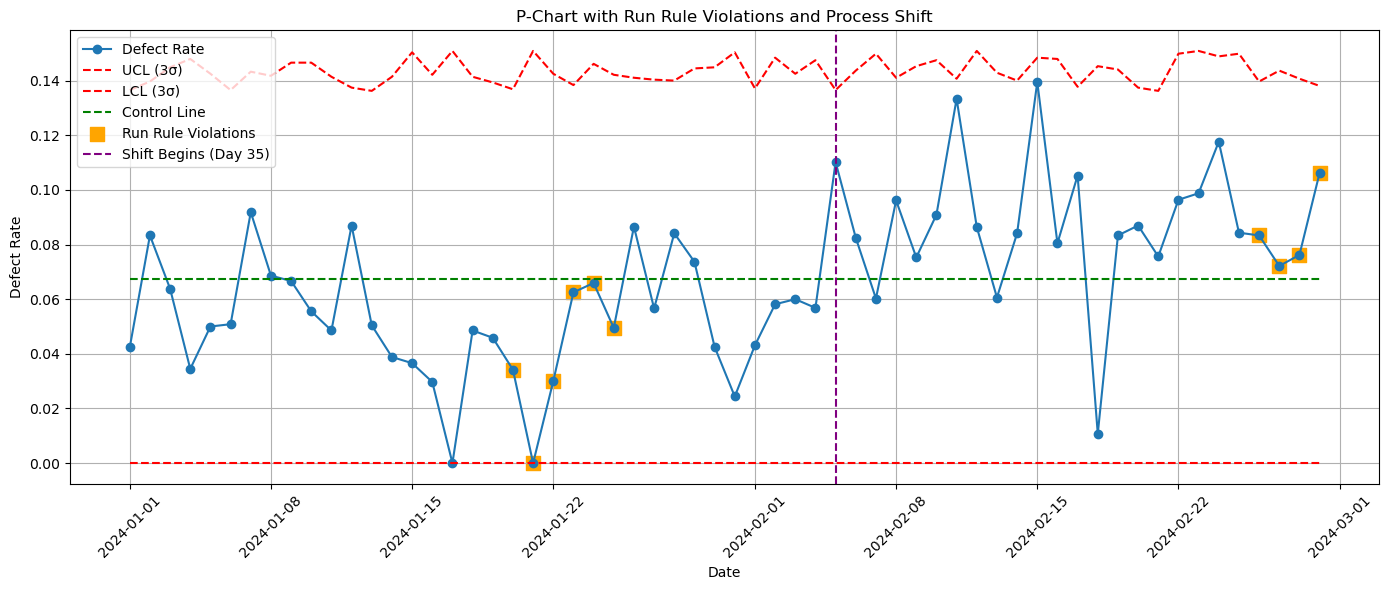

In [10]:
# Plot with violations highlighted
plt.figure(figsize=(14,6))

# Main defect rate line
plt.plot(df['Date'],df['Defects_Rate'],marker='o',label='Defect Rate')

# Control limits and center
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3σ)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3σ)')
plt.plot(df['Date'],df['p_bar'],linestyle='--',color='green',label='Control Line')

# Highlight violations
plt.scatter(violations['Date'],violations['Defects_Rate'],
            color='orange',s=100,marker='s',label='Run Rule Violations')

# Add shift marker
plt.axvline(df['Date'].iloc[35],color='purple',linestyle='--',label='Shift Begins (Day 35)')

# Final touches
plt.title('P-Chart with Run Rule Violations and Process Shift')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
#Assume specs : acceptable defect rate between 2% and 8%
USL , LSL = 0.08,0.02
process_sigma = df['Defects_Rate'].std()

Cp = (USL - LSL) / (6 * process_sigma)
Cpk = min((USL - p_bar),(p_bar - LSL)) / (3 * process_sigma)

print(f"Cp: {Cp:.2f}, Cpk: {Cpk:.2f}")

Cp: 0.34, Cpk: 0.14


In [12]:
# bootstrapping 
boot_means = [np.mean(np.random.choice(df['Defects_Rate'],size=len(df),replace = True))for _ in range(1000)]
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means,97.5)

print(f"95% CI for average defect Rate:({ci_lower:.4f},{ci_upper:.4f})")

95% CI for average defect Rate:(0.0602,0.0743)


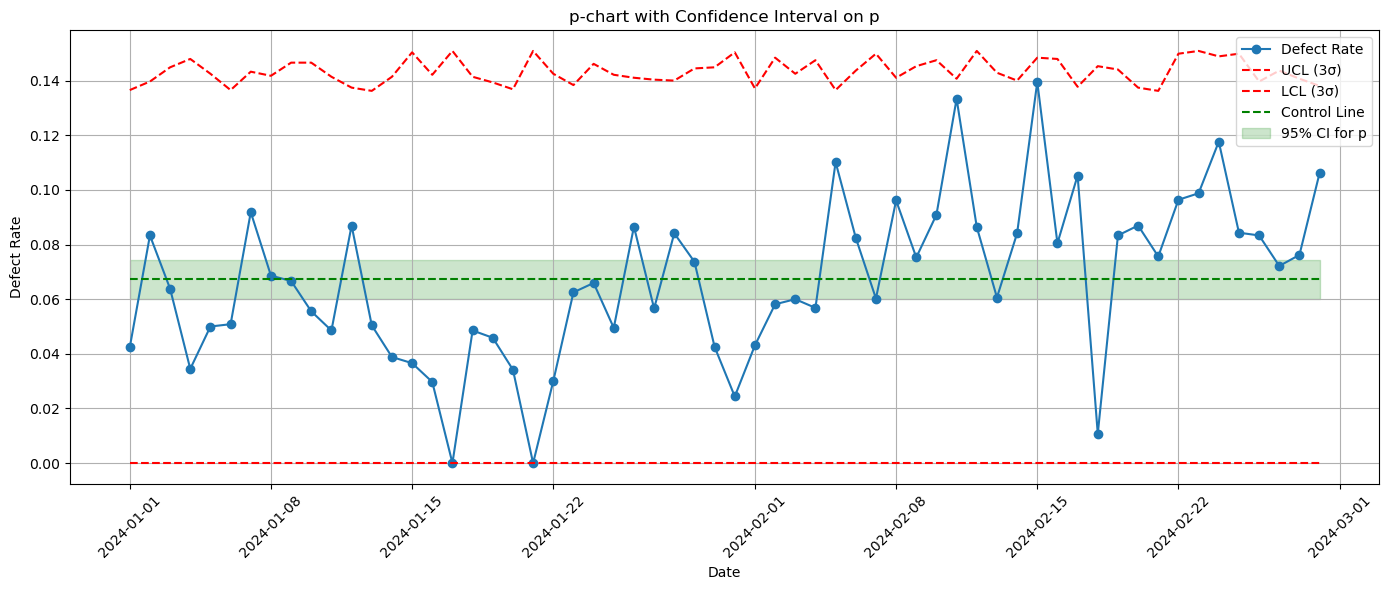

In [13]:
#Adding a shaded confidence interval
plt.figure(figsize=(14,6))

# Main defect rate line
plt.plot(df['Date'],df['Defects_Rate'],marker='o',label='Defect Rate')

# Control limits and center
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3σ)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3σ)')
plt.plot(df['Date'],df['p_bar'],linestyle='--',color='green',label='Control Line')


# add this for confidence interval shading 

plt.fill_between(
    df['Date'],ci_lower,ci_upper,
    color= 'green', alpha=0.2 , label='95% CI for p'
)

#finalize chaert

plt.title('p-chart with Confidence Interval on p')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

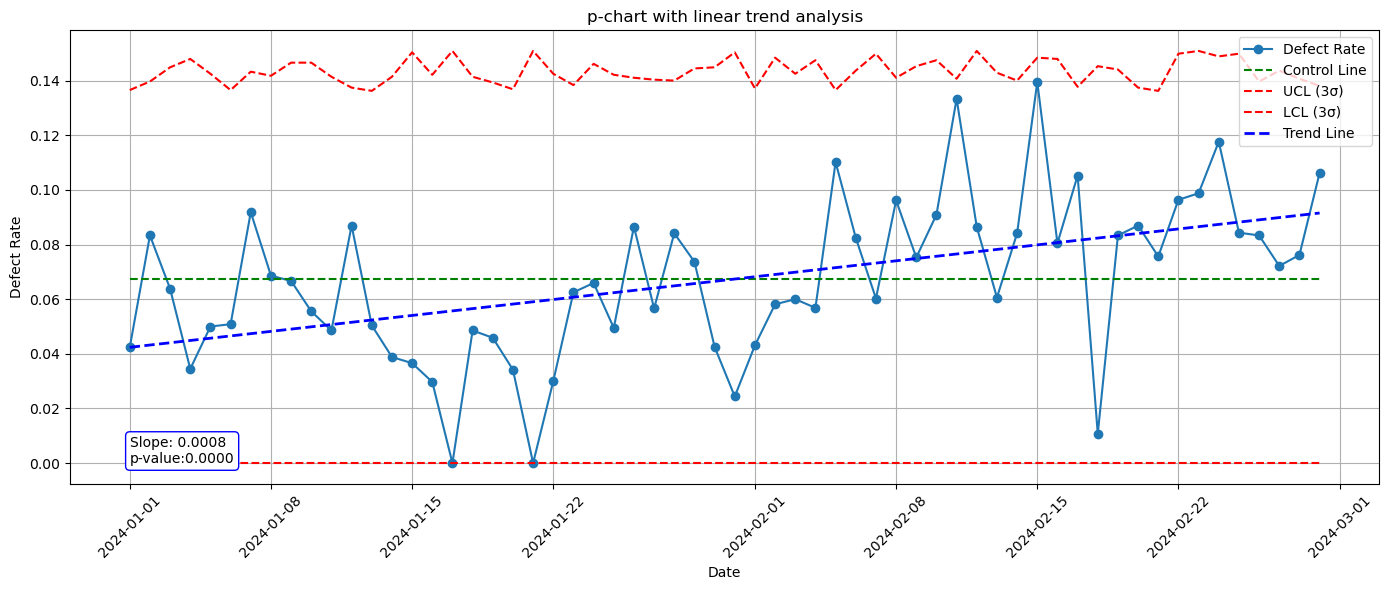

In [14]:
from scipy.stats import linregress
import matplotlib.pyplot as plt 

# step 1:  Create a numeric "Day" column
df['Day'] = range(1, len(df)+1)

# step 2: Run linear regression on defect rate over time 
trend_result = linregress(df['Day'],df['Defects_Rate'])

slope = trend_result.slope
p_value = trend_result.pvalue
intercept = trend_result.intercept

#step 3: create trend line values
df['Trend_Line'] = intercept + slope * df['Day']

#step 4: Plot p-chart with trend line
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defects_Rate'],marker='o',label='Defect Rate')
plt.plot(df['Date'],df['p_bar'],linestyle='--',color='green',label='Control Line')

plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3σ)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3σ)')


# add trend line 
plt.plot(df['Date'],df['Trend_Line'],linestyle='--',color='blue',linewidth=2,label='Trend Line')

#step5: Annotate with slope and p -value

plt.text(df['Date'].iloc[0], min(df['Defects_Rate']),
         f"Slope: {slope:.4f}\np-value:{p_value:.4f}",
         fontsize=10, bbox=dict(facecolor='white',edgecolor='blue',boxstyle='round'))

#final touches
plt.title('p-chart with linear trend analysis')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

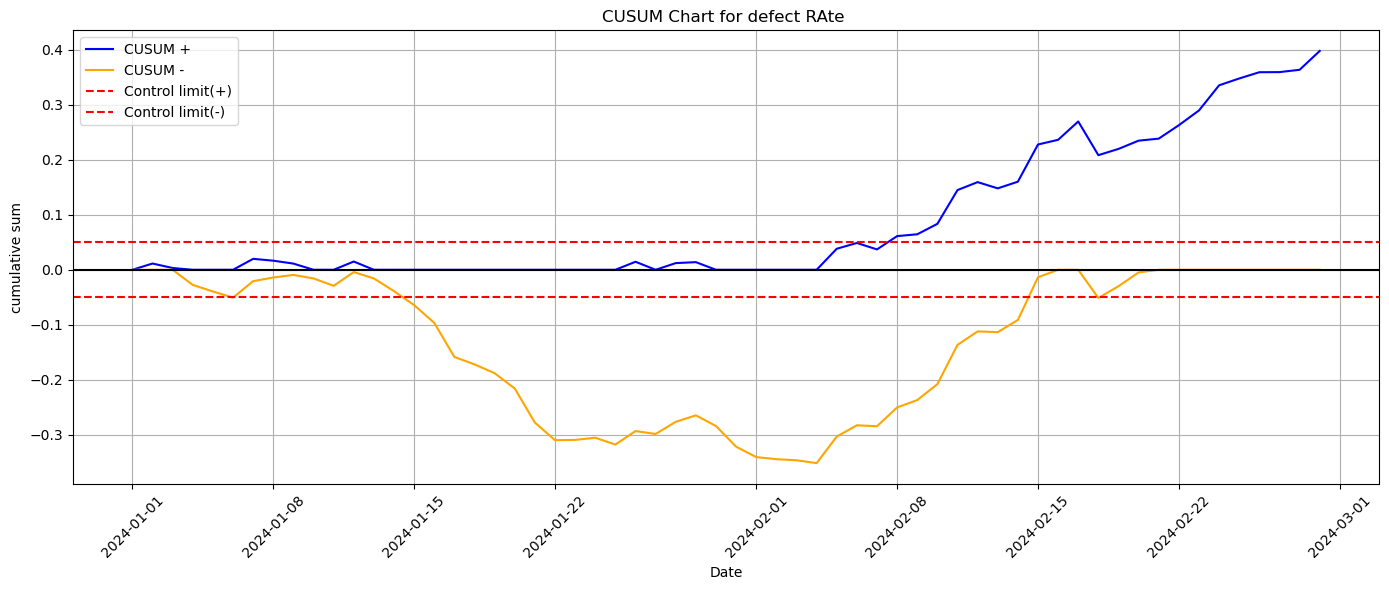

In [15]:
# Cusum  Parameters

target = df['Defects_Rate'].mean() # p
k=0.005
h=0.05

# Initializes lists
cusum_pos = [0]
cusum_neg = [0]

#Calculate CUSUM values

for i in range(1, len(df)):
    p_i = df.loc[i,'Defects_Rate']
    s_pos = max(0, cusum_pos[-1]+(p_i - target -k))
    s_neg = min(0,cusum_neg[-1]+ (p_i - target + k))
    cusum_pos.append(s_pos)
    cusum_neg.append(s_neg)

# Add to dataframe
df['CUSUM_Pos']= cusum_pos
df['CUSUM_Neg']= cusum_neg

#plot CUSUM
plt.figure(figsize=(14,6))


plt.plot(df['Date'],df['CUSUM_Pos'],color='blue',label='CUSUM +')
plt.plot(df['Date'],df['CUSUM_Neg'],color='Orange',label='CUSUM -')
plt.axhline(h,color='red',linestyle='--',label='Control limit(+)')
plt.axhline(-h,color='red',linestyle='--',label='Control limit(-)')
plt.axhline(0,color='black',linestyle='-')
plt.title('CUSUM Chart for defect RAte ')
plt.xlabel('Date')
plt.ylabel('cumulative sum')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

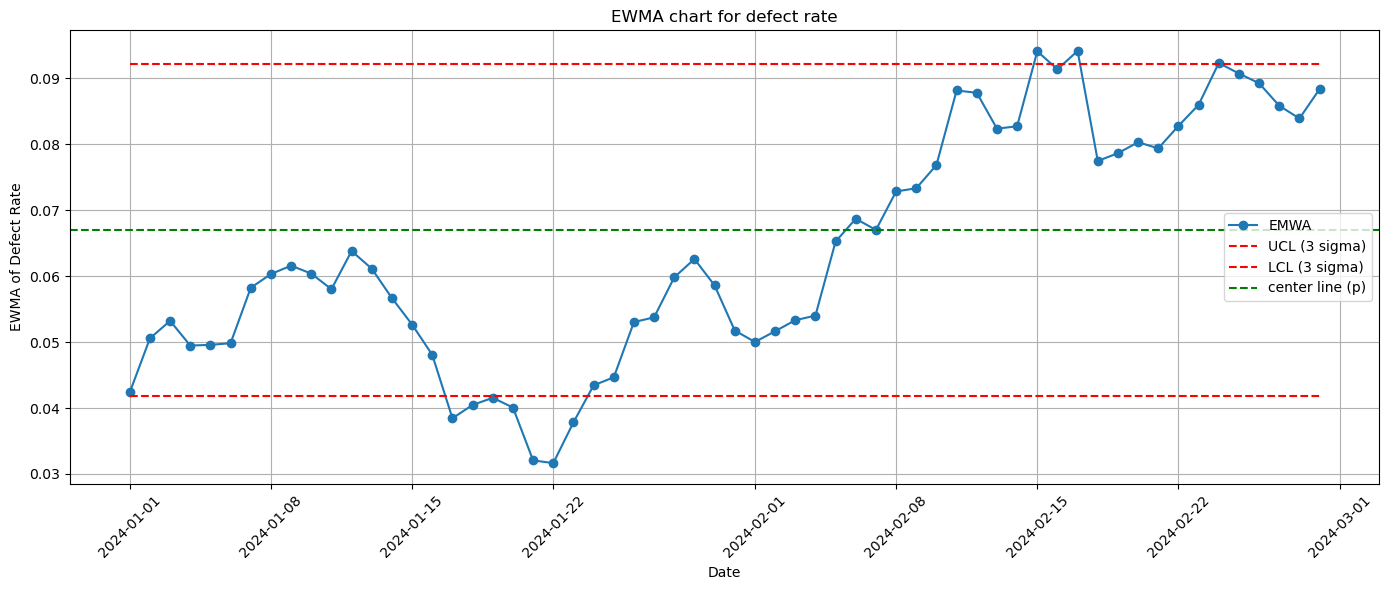

In [18]:
# EMWA parameters
lambda_ = 0.2  #Smoothing constant (0.1-0.3 common)
L=3      #control limit multiplyer

#intialise emwa

df['EWMA'] = 0.0
df.loc[0,'EWMA'] = df.loc[0,'Defects_Rate']

#compute EMWA for each day
for i in range(1,len(df)):
    df.loc[i,'EWMA'] = lambda_ * df.loc[i,'Defects_Rate'] + (1-lambda_) * df.loc[i-1,'EWMA']


#estimate sigma (average over entire series)
p_bar = df['Defects_Rate'].mean()
avg_n = df['Sample_Size'].mean()
sigma = np.sqrt(p_bar*(1-p_bar)/avg_n)

#control limits
df['UCL_EWMA'] = p_bar + L*sigma * np.sqrt(lambda_/(2-lambda_))
df['LCL_EWMA'] = p_bar - L*sigma * np.sqrt(lambda_/(2-lambda_))

#plot EMWA

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['EWMA'], label='EMWA',marker='o')
plt.plot(df['Date'], df['UCL_EWMA'], label='UCL (3 sigma)', linestyle='--',color = 'red')
plt.plot(df['Date'], df['LCL_EWMA'], label='LCL (3 sigma)', linestyle='--', color = 'red')
plt.axhline(y=p_bar, color='green', linestyle='--', label='center line (p)')
plt.title('EWMA chart for defect rate')
plt.xlabel('Date')
plt.ylabel('EWMA of Defect Rate')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

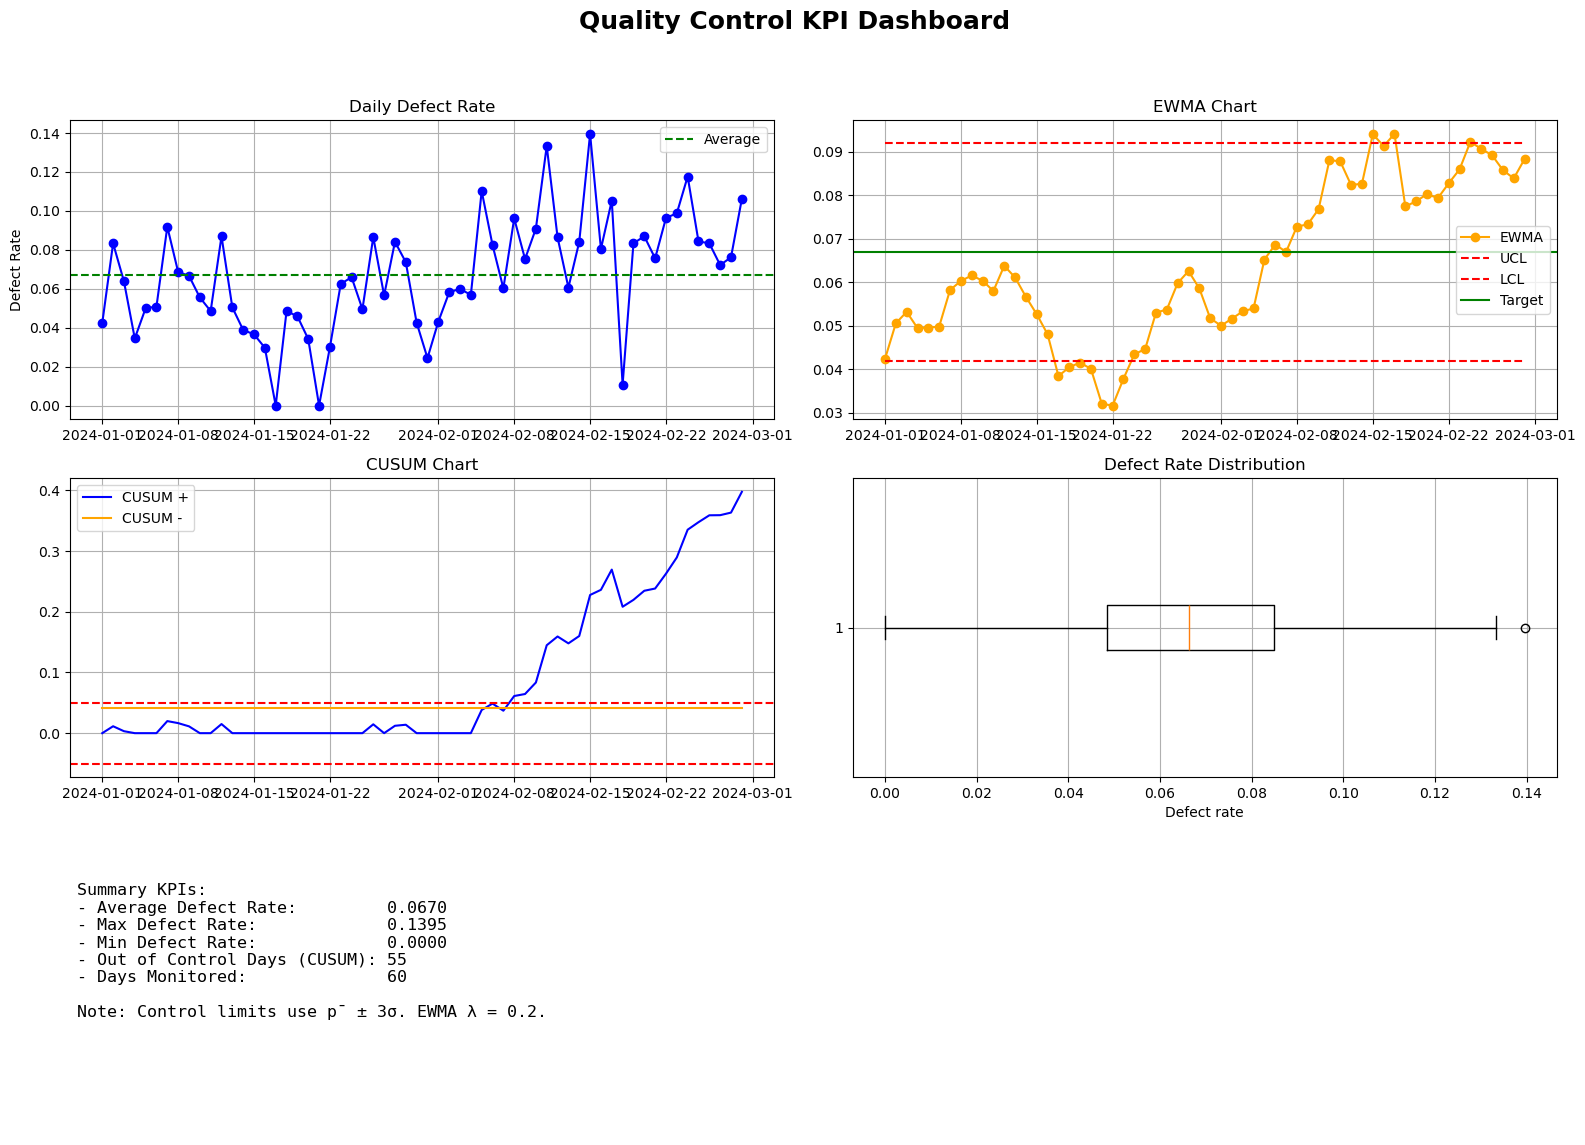

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Recalculate needed KPIs
avg_defect_rate = df['Defects_Rate'].mean()
max_defect_rate = df['Defects_Rate'].max()
min_defect_rate = df['Defects_Rate'].min()
out_of_control_days = (df['CUSUM_Pos']>0.05).sum()+(df['CUSUM_Neg']<-0.05).sum()

# create subplot grid
fig, axs = plt.subplots(3,2,figsize=(16,12))
fig.suptitle('Quality Control KPI Dashboard',fontsize=18,fontweight='bold')

# ------1. Daily Defect Rate ------
axs[0,0].plot(df['Date'],df['Defects_Rate'],marker='o',color='blue')
axs[0,0].axhline(avg_defect_rate,color='green',linestyle='--',label='Average')
axs[0,0].set_title('Daily Defect Rate')
axs[0,0].set_ylabel('Defect Rate')
axs[0,0].legend()
axs[0,0].grid(True)


# ------2. EWMA Chart
axs[0,1].plot(df['Date'],df['EWMA'],marker='o',label='EWMA',color='orange')
axs[0,1].plot(df['Date'],df['UCL_EWMA'],linestyle='--',label='UCL',color='red')
axs[0,1].plot(df['Date'],df['LCL_EWMA'],linestyle='--',label='LCL',color='red')
axs[0,1].axhline(avg_defect_rate,color='green',linestyle='-',label='Target')
axs[0,1].set_title('EWMA Chart')
axs[0,1].legend()
axs[0,1].grid(True)


# -------3. CUSUM Chart
axs[1,0].plot(df['Date'],df['CUSUM_Pos'],label='CUSUM +',color='blue')
axs[1,0].plot(df['Date'],df['LCL_EWMA'],label='CUSUM -',color='orange')
axs[1,0].axhline(0.05, color='red',linestyle='--')
axs[1,0].axhline(-0.05, color='red',linestyle='--')
axs[1,0].set_title('CUSUM Chart')
axs[1,0].legend()
axs[1,0].grid(True)


# ------4. Boxplot of Defect Rates
axs[1,1].boxplot(df['Defects_Rate'],vert=False)
axs[1,1].set_title('Defect Rate Distribution')
axs[1,1].set_xlabel('Defect rate')
axs[1,1].grid(True)


# -----5. KPI Summary
axs[2,0].axis('off')
kpi_text = f"""
Summary KPIs:
- Average Defect Rate:         {avg_defect_rate:.4f}
- Max Defect Rate:             {max_defect_rate:.4f}
- Min Defect Rate:             {min_defect_rate:.4f}
- Out of Control Days (CUSUM): {out_of_control_days}
- Days Monitored:              {len(df)}

Note: Control limits use p̄ ± 3σ. EWMA λ = 0.2.
"""

axs[2,0].text(0.01,0.9,kpi_text,fontsize=12,verticalalignment='top', family='monospace')


# -----6. Empty space or add more content -----
axs[2,1].axis('off')    # Placeholder for future KPI

plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()